In [1]:
# importing the libraries here
import os
import tensorflow as tf
import IPython.display as display
import numpy as np
import PIL.Image
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_hub as hub
import requests
from io import BytesIO


In [2]:
# replace the image file with your input and style image
content_path = "pxfuel.jpg"
style_path = "img1.jpg"

In [3]:
# this function will convert the given tensor to image assuming tensor has float values b/w 0 to 1
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
# this function used to load the image
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
# this function displays the color image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

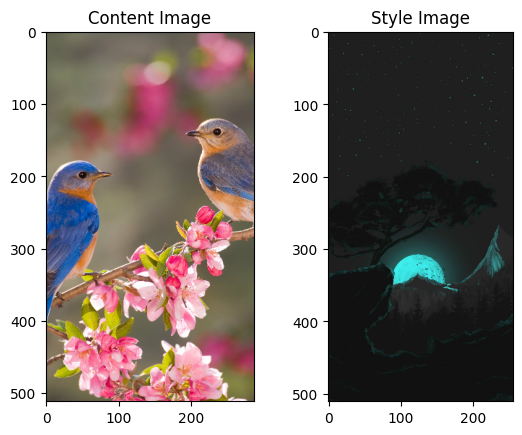

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
# loading VGG model with imagenet weights
# imagenet weight means the weight when model was trained on imagenet dataset
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [8]:
# choosing the layer from which content we consider the content
content_layers = ['block5_conv2']

# layers which we consider for the style
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [11]:
# making our model for the style transfer
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                        outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [14]:
image = tf.Variable(content_image)

In [15]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
# using adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
style_weight=1e-2
content_weight=1e4

In [18]:
# defining the loss function which is combination of both content loss and style loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # adding the both loss
    loss = style_loss + content_loss
    return loss

In [19]:
# defining the training step for the image and backpropagating using gradient descent
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

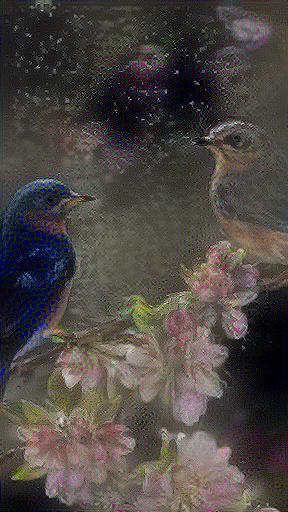

In [20]:
epochs = 1000
for i in range(epochs):
    train_step(image)
tensor_to_image(image)